In [115]:
import os
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks, hilbert
import pickle
import ipywidgets as widgets

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils, ensemble
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sklearn.linear_model import LinearRegression, HuberRegressor
from sleeprnn.data import utils, stamp_correction

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

In [35]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT'
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}
eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]
fs = 200

In [215]:
config = eval_configs[1]

# Collect predictions
print("\nLoading", config)
source_dataset = reader.load_dataset(config["dataset_name"], verbose=False)
pink = reader.load_dataset(constants.PINK_NAME, verbose=False)
pink.event_name = source_dataset.event_name
_, _, test_ids_list = get_partitions(source_dataset, config["strategy"], config["seeds"])
n_folds = len(test_ids_list)
pred_dict = {}
for model_version in models:
    pred_dict[model_version] = {}
    tmp_pert_dict = fig_utils.get_red_predictions_for_pink(
        model_version, config["strategy"], source_dataset, config["expert"], 
        pink_dataset=pink, verbose=False)
    perturbations = list(tmp_pert_dict.keys())
    for perturbation_name in perturbations:
        pred_dict[model_version][perturbation_name] = {}
        tmp_dict = tmp_pert_dict[perturbation_name]
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][perturbation_name][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}   
print("Done.")


Loading {'dataset_name': 'mass_kc', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Creating cache that does not exist


/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Done.


In [216]:
# Medir numero de detecciones por minuto (epm)
scales = ['scale-1.0', 'scale-1.5', 'scale-2.0']
n_folds = 15
subject_ids = pink.all_ids
table = []
for model_version in models:
    for scale in scales:
        for k in range(n_folds):
            for subject_id in subject_ids:
                this_pred = pred_dict[model_version][scale][k][subject_id]
                table.append(
                    {'model': model_version, 'scale': scale, 'fold': k, 'subject_id': subject_id, 'n_events': this_pred.shape[0]}
                )
table = pd.DataFrame(table)

In [217]:
total_n2_hours = np.concatenate(pink.get_pages(pages_subset=constants.N2_RECORD)).size * pink.page_duration / 3600

In [218]:
# mean and std across folds, each fold predicts on 25 hours of signal

density_table = table.drop(columns=["subject_id"]).groupby(by=["model", "scale", "fold"]).sum()
density_per_hour_table = density_table / total_n2_hours
density_per_hour_table = density_per_hour_table.rename(columns={'n_events': 'density_hour'})
density_per_hour_table = density_per_hour_table.reset_index()
density_table = density_table.reset_index()
density_table_per_hour_mean = density_per_hour_table.drop(columns=["fold"]).groupby(by=["model", "scale"]).mean().add_suffix("_mean")
density_table_per_hour_std = density_per_hour_table.drop(columns=["fold"]).groupby(by=["model", "scale"]).std(ddof=0).add_suffix("_std")
density_table_sum = density_table.drop(columns=["fold"]).groupby(by=["model", "scale"]).sum().add_suffix("_sum")
density_table_mean = density_table.drop(columns=["fold"]).groupby(by=["model", "scale"]).mean().add_suffix("_mean")
density_table_std = density_table.drop(columns=["fold"]).groupby(by=["model", "scale"]).std(ddof=0).add_suffix("_std")
density_table_stats = pd.concat(
    [density_table_mean, density_table_std, density_table_sum, density_table_per_hour_mean, density_table_per_hour_std], axis=1).reset_index()
density_table_stats

,model,scale,n_events_mean,n_events_std,n_events_sum,density_hour_mean,density_hour_std
0,v2_cwt1d,scale-1.0,319.933333,32.866329,4799,12.797333,1.314653
1,v2_cwt1d,scale-1.5,5090.666667,352.743848,76360,203.626667,14.109754
2,v2_cwt1d,scale-2.0,11919.933333,726.904897,178799,476.797333,29.076196
3,v2_time,scale-1.0,329.866667,48.443598,4948,13.194667,1.937744
4,v2_time,scale-1.5,5156.066667,558.569657,77341,206.242667,22.342786
5,v2_time,scale-2.0,12862.933333,1162.173852,192944,514.517333,46.486954


In [219]:
# find unique events (OR ensemble) -> intervals detected by at least one checkpoint
scales = ['scale-1.0', 'scale-1.5', 'scale-2.0']
n_folds = 15
subject_ids = pink.all_ids
unique_events = {}
for model_version in models:
    unique_events[model_version] = {}
    for scale in scales:
        unique_events[model_version][scale] = {}
        n_events = 0
        for subject_id in subject_ids:
            tmp_signal = np.zeros(int(fs * 3600))
            for k in range(n_folds):
                this_pred = pred_dict[model_version][scale][k][subject_id]
                for m in this_pred:
                    tmp_signal[m[0]:m[1]+1] = tmp_signal[m[0]:m[1]+1] + 1
            tmp_signal = (tmp_signal>0).astype(np.int32)
            unique_stamps = utils.seq2stamp(tmp_signal)
            # unique_stamps = stamp_correction.combine_close_stamps(unique_stamps, fs, min_separation=0.3)
            unique_events[model_version][scale][subject_id] = unique_stamps
            n_events += unique_stamps.shape[0]
        print("%s - %s: total events %d" % (model_version, scale, n_events))

v2_time - scale-1.0: total events 614
v2_time - scale-1.5: total events 7818
v2_time - scale-2.0: total events 18178
v2_cwt1d - scale-1.0: total events 594
v2_cwt1d - scale-1.5: total events 7906
v2_cwt1d - scale-2.0: total events 17224


0.32 1.12
0.2 2.08
0.2 2.4
0.32 1.04
0.16 2.08
0.2 2.44


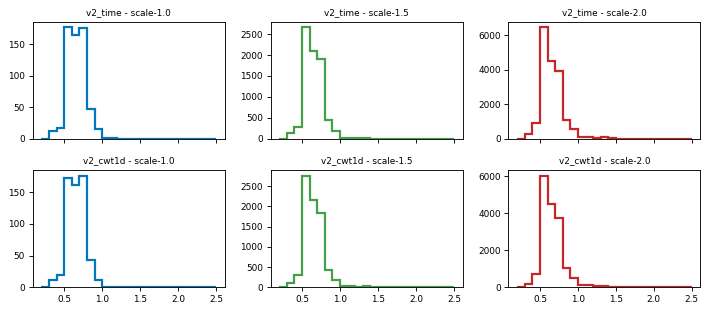

In [220]:
bins = np.arange(0.2, 2.5 + 0.001, 0.1)
colors = [viz.PALETTE['blue'], viz.PALETTE['green'], viz.PALETTE['red']]
fig, axes = plt.subplots(2, 3, figsize=(9, 4), dpi=80, sharex=True)
for i, model_version in enumerate(models):
    for j, scale in enumerate(scales):
        all_events = [unique_events[model_version][scale][s] for s in subject_ids]
        all_events = np.concatenate(all_events, axis=0)
        durations = (all_events[:, 1] - all_events[:, 0] + 1) / fs
        if durations.size > 0:
            print(durations.min(), durations.max())
        ax = axes[i, j]
        ax.tick_params(labelsize=8)
        ax.hist(durations, bins=bins, histtype='step', color=colors[j], linewidth=2)
        ax.set_title("%s - %s" % (model_version, scale), fontsize=8)
plt.tight_layout()
plt.show()

In [221]:
# KC: only scale 1.0
# Observe some detections from subject 1


selected_subject_id = 1
selected_scale = "scale-1.0"

print(unique_events['v2_time'][selected_scale][selected_subject_id].shape)
tmp_marks = unique_events['v2_time'][selected_scale][selected_subject_id]
print(tmp_marks)
durations = (tmp_marks[:, 1] - tmp_marks[:, 0] + 1) / fs
print(durations)

(23, 2)
[[ 22616  22759]
 [ 46952  47095]
 [112912 113015]
 [176280 176383]
 [200528 200655]
 [264480 264591]
 [304496 304695]
 [310920 311031]
 [318112 318223]
 [335832 335959]
 [348752 348847]
 [372968 373103]
 [395824 395935]
 [396464 396639]
 [421512 421647]
 [425376 425519]
 [446064 446207]
 [506128 506279]
 [555880 555975]
 [590528 590663]
 [674424 674543]
 [706208 706335]
 [709544 709703]]
[0.72 0.72 0.52 0.52 0.64 0.56 1.   0.56 0.56 0.64 0.48 0.68 0.56 0.88
 0.68 0.72 0.72 0.76 0.48 0.68 0.6  0.64 0.8 ]


In [193]:
# mostra todas las probabilidades predichas para dicho sujeto
models = [constants.V2_TIME, constants.V2_CWT1D]
print("\nLoading", config)
source_dataset = reader.load_dataset(config["dataset_name"], verbose=False)
_, _, test_ids_list = get_partitions(source_dataset, config["strategy"], config["seeds"])
n_folds = len(test_ids_list)
proba_dict = {}
for model_version in models:
    proba_dict[model_version] = []
    tmp_pert_dict = fig_utils.get_red_predictions_for_pink(
        model_version, config["strategy"], source_dataset, config["expert"], 
        pink_dataset=pink, verbose=False)
    tmp_dict = tmp_pert_dict[selected_scale]
    for k in tmp_dict.keys():
        this_proba = tmp_dict[k][constants.TEST_SUBSET].get_subject_probabilities(selected_subject_id, return_adjusted=True)
        this_proba = np.repeat(this_proba, 8)
        proba_dict[model_version].append(this_proba)
print("Done.")


Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Done.


In [194]:
tmp_signal = pink.get_subject_signal(subject_id=selected_subject_id, normalize_clip=False)
tmp_marks = unique_events['v2_time'][selected_scale][selected_subject_id]
print("%d marks" % tmp_marks.shape[0])

4 marks


In [195]:
def show_mark(mark_index):
    mark = tmp_marks[mark_index]
    scale_factor = float(selected_scale.split("-")[-1])
    window_duration = 5
    fs = pink.fs
    center_sample = int(mark.mean())
    window_size = int(window_duration * fs)
    start_sample = int(center_sample - window_size // 2)
    end_sample = start_sample + window_size
    segment_signal = scale_factor * tmp_signal[start_sample:end_sample]
    time_axis = np.arange(start_sample, end_sample) / fs
    
    start_spindle_relative = mark[0] - start_sample
    end_spindle_relative = mark[1] - start_sample
    
    # measure params
    filt_signal = param_filtering_fn(segment_signal, fs, pink.event_name)
    filt_signal_event = filt_signal[start_spindle_relative:end_spindle_relative]
    event_duration = (mark[1] - mark[0] + 1) / fs
    event_amplitude = param_amplitude_fn(filt_signal_event, fs, pink.event_name)
    if pink.event_name == constants.SPINDLE:
        event_frequency = param_frequency_fn(filt_signal_event, fs)
    else:
        event_frequency = None

    y_lim = 100

    fig, axes = plt.subplots(3, 1, figsize=(4, 4.5), dpi=120, sharex=True)
    ax = axes[0]
    ax.plot(
        time_axis, segment_signal, linewidth=0.8, label="EEG 0-35 Hz", 
        color=viz.PALETTE['blue'])
    # ax.plot(
    #    time_axis[start_spindle_relative:end_spindle_relative], segment_signal[start_spindle_relative:end_spindle_relative], linewidth=1.1,
    #    color=viz.PALETTE['red'])
    ax.plot(mark/fs, [-y_lim*0.8]*2, linewidth=4, color=viz.PALETTE['red'])
    ax.set_ylim([-y_lim, y_lim])
    ax.tick_params(labelsize=8)
    ax.set_xticks(np.arange(start_sample/fs, end_sample/fs + 0.001, 2))
    ax.set_xticks(np.arange(start_sample/fs, end_sample/fs + 0.001, 0.25), minor=True)
    ax.set_yticks(np.arange(-y_lim, y_lim + 0.001, 50))
    ax.set_yticks(np.arange(-y_lim, y_lim + 0.001, 25), minor=True)
    ax.grid(which="minor")
    ax.legend(loc="upper right", fontsize=8)
    if event_frequency is None:
        param_str = 'd=%1.2f s, App=%1.1f $\mu$V' % (event_duration, event_amplitude)
    else:
        param_str = 'd=%1.2f s, App=%1.1f $\mu$V, f=%1.1f Hz' % (event_duration, event_amplitude, event_frequency)
    ax.set_title("PINK-S%02d. %s" % (selected_subject_id, param_str), fontsize=8)

    ax = axes[1]
    model_version = "v2_time"
    for proba in proba_dict[model_version]:
        proba_segment = proba[start_sample:end_sample]
        ax.fill_between(time_axis, 0, proba_segment, facecolor=viz.PALETTE['red'], alpha=0.1)
        # ax.plot(time_axis, proba_segment, linewidth=1.5, alpha=0.3, color=viz.PALETTE['red'])
    ax.tick_params(labelsize=8)
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid(which="minor")
    ax.axhline(0.5, linewidth=0.8, color="k", label="REDv2-Time", linestyle="--")
    ax.axhline(0.5*0.85, linewidth=0.8, color="k", linestyle="--")
    ax.legend(loc="upper right", fontsize=8)

    ax = axes[2]
    model_version = "v2_cwt1d"
    for proba in proba_dict[model_version]:
        proba_segment = proba[start_sample:end_sample]
        ax.fill_between(time_axis, 0, proba_segment, facecolor=viz.PALETTE['red'], alpha=0.1)
        # ax.plot(time_axis, proba_segment, linewidth=1.5, alpha=0.3, color=viz.PALETTE['red'])
    ax.tick_params(labelsize=8)
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid(which="minor")
    ax.axhline(0.5, linewidth=0.8, color="k", label="REDv2-CWT", linestyle="--")
    ax.axhline(0.5*0.85, linewidth=0.8, color="k", linestyle="--")
    ax.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()

In [196]:
print("%d marks" % tmp_marks.shape[0])

init_mark_idx = 0

style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda mark_idx: show_mark(mark_idx),
    mark_idx=widgets.IntSlider(
        min=0, max=tmp_marks.shape[0]-1, step=1, value=init_mark_idx, 
        continuous_update=False,
        style=style,
        layout=layout
    ));

4 marks


interactive(children=(IntSlider(value=0, continuous_update=False, description='mark_idx', layout=Layout(width=…

In [222]:
# parameters of unique events

selected_scale = "scale-1.0"

table = {
    'Detector': [],
    'Duration': [], 
    'AmplitudePP': [],
    'Frequency': [],
}
scale_factor = float(selected_scale.split("-")[-1])
print("Scaling by", scale_factor)
for model_version in models:
    tmp_table = {
        'Duration': [], 
        'AmplitudePP': [],
        'Frequency': [],
    }
    for subject_id in pink.all_ids:
        subject_signal = scale_factor * pink.get_subject_signal(subject_id, normalize_clip=False)
        events = unique_events[model_version][selected_scale][subject_id]
        if events.size == 0:
            continue
        # Duration
        duration = (events[:, 1] - events[:, 0] + 1) / fs
        tmp_table['Duration'].append(duration)
        # Amplitude
        filt_signal = param_filtering_fn(subject_signal, fs, pink.event_name)
        signal_events = [filt_signal[e[0]:e[1]+1] for e in events]
        amplitude = np.array([param_amplitude_fn(s, fs, pink.event_name) for s in signal_events])
        tmp_table['AmplitudePP'].append(amplitude)
        # Frequency
        if pink.event_name == constants.SPINDLE:
            freq_central = np.array([param_frequency_fn(s, fs) for s in signal_events])
        else:
            freq_central = np.array([1] * len(signal_events))
        tmp_table['Frequency'].append(freq_central)
    table['Detector'].append(model_version)
    for key in tmp_table.keys():
        table[key].append(np.concatenate(tmp_table[key]))
print("Done.")

Scaling by 1.0


/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


Done.


31.11587915596415 103.36559096522691


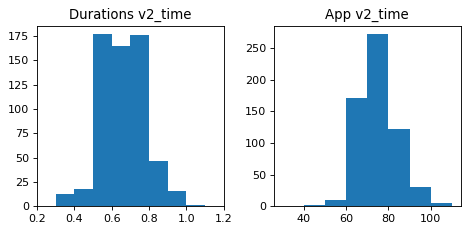

32.1249939135692 103.36559096522691


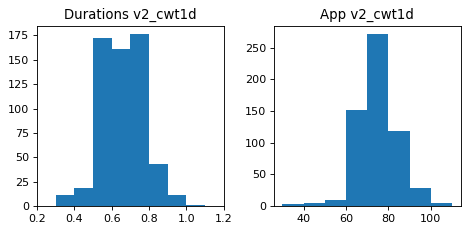

In [232]:
for i, model_version in enumerate(table['Detector']):
    durations = table['Duration'][i]
    amplitudes = table['AmplitudePP'][i]
    if pink.event_name == constants.SPINDLE:
        frequencies = table['Frequency'][i]
        n_params = 3
    else:
        frequencies = None
        n_params = 2
    fig, axes = plt.subplots(1, n_params, figsize=(3*n_params, 3), dpi=80)
    
    ax = axes[0]
    ax.set_title("Durations %s" % model_version)
    if frequencies is None:
        ax.hist(durations, bins=np.arange(0.2, 1.1 + 1e-3, 0.1))
        ax.set_xlim([0.2, 1.2])
    else:
        ax.hist(durations, bins=np.arange(0.2, 1.1 + 1e-3, 0.1))
        ax.set_xlim([0.2, 1.1])
    
    ax = axes[1]
    if frequencies is None:
        ax.set_title("App %s" % model_version)
        print(amplitudes.min(), amplitudes.max())
        ax.hist(amplitudes, bins=np.arange(30, 110 + 1e-3, 10))
    else:
        ax.hist(amplitudes, bins=np.arange(10, 50 + 1e-3, 5))
        ax.set_xlim([10, 50])
    
    if frequencies is not None:
        ax = axes[2]
        ax.set_title("Freqs %s" % model_version)
        ax.hist(frequencies, bins=np.arange(9, 17 + 1e-3, 0.5))
        ax.set_xlim([9, 17])
    
    plt.tight_layout()
    plt.show()